## **Building a Spatial-Temporal GNN Model for Predicting NYC Traffic**

by Charles Shaviro, Yi-Ting Tsai, Leda Liang

In this notebook, we walk through how to load in and process traffic sensor data from NYC's Department of Transportation, feed it into a Spatial-Temporal Graph Attention Model, experiment with different model architectures, tune hyperparameters and conduct final testing, reporting metrics along the way.


First, we install and import the libraries we will use and mount our google drive.

In [ ]:
!pip install torch-geometric


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
import time
import os
import pandas as pd
import numpy as np


We initialize our first version of the ST-GAT Model

In [ ]:


# -------------------------------
# ST-GAT Model Version 0
# -------------------------------

class ST_GAT(nn.Module):
    """
    Spatial-Temporal Graph Attention Network.
    This initial version uses a GAT layer followed by two LSTMs, then a linear layer for prediction.
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        # experimented with different versions, these two settings work well
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # GAT layer
        # in_channels is the dimension of features at each node
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels, heads=heads, dropout=0, concat=False)

        # LSTM layers
        # input to LSTM1: (seq_length, batch_size, n_nodes)
        self.lstm1 = nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        self._init_lstm(self.lstm1)
        self.lstm2 = nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        self._init_lstm(self.lstm2)

        # fully-connected output layer
        self.linear = nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        nn.init.xavier_uniform_(self.linear.weight)

    def _init_lstm(self, lstm):
        for name, param in lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)

    def forward(self, data, device):
        x, edge_index = data.x, data.edge_index

        if device != 'cpu':
            x = x.cuda()

        # GAT
        x = self.gat(x, edge_index)  # (N*batch, in_channels)
        x = F.dropout(x, self.dropout, training=self.training)

        # rReshape to (batch_size, n_node, features)
        batch_size = data.num_graphs
        n_node = int(data.num_nodes / batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))

        # move dims to (seq_length, batch_size, n_nodes)
        x = torch.movedim(x, 2, 0)  # (F, batch_size, n_node)

        # LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        # Take the last time-step output of (batch_size, lstm2_hidden_size)
        x = x[-1, :, :]

        # finally linear layer to predict future steps
        x = self.linear(x)
        x = torch.reshape(x, (batch_size, n_node, self.n_pred))
        x = torch.reshape(x, (batch_size*n_node, self.n_pred))

        return x

We load in our datasets and inspect them

In [ ]:
full_dataset = pd.read_csv("/content/drive/MyDrive/CS224W Data/final_cleaned_full_dataset.csv")

nodes_df = pd.read_csv("/content/drive/MyDrive/CS224W Data/final_nodes.csv")
edges_df = pd.read_csv("/content/drive/MyDrive/CS224W Data/final_edges.csv")

In [ ]:
print(full_dataset.columns)
print(nodes_df.columns)
print(edges_df.columns)

Index(['Unnamed: 0', 'sensor', '2024-09-01 00:00', '2024-09-01 00:05',
       '2024-09-01 00:10', '2024-09-01 00:15', '2024-09-01 00:20',
       '2024-09-01 00:25', '2024-09-01 00:30', '2024-09-01 00:35',
       ...
       '2024-10-31 23:25', '2024-10-31 23:30', '2024-10-31 23:35',
       '2024-10-31 23:40', '2024-10-31 23:45', '2024-10-31 23:50',
       '2024-10-31 23:55', 'latitude', 'longitude', 'sensor_id'],
      dtype='object', length=17573)
Index(['sensor_id', 'latitude', 'longitude'], dtype='object')
Index(['u', 'v'], dtype='object')


With the following two cells, we conduct data sorting and linking of the two datasets together, creating a dictionary to map from sensor_id and node_index and ensuring the dataframes are sorted the same way.

In [ ]:
nodes_df = nodes_df.reset_index(drop=True)

# ensure sensor_id is unique and sorted if needed
nodes_df = nodes_df.sort_values('sensor_id')
nodes_df['node_index'] = range(len(nodes_df))

# ensure nodes_df is sorted by node_index to define a consistent order
nodes_df = nodes_df.sort_values('node_index').reset_index(drop=True)

# create a dictionary to map from sensor_id to node_index
sensor_to_idx = dict(zip(nodes_df['sensor_id'], nodes_df['node_index']))

# add node_index to full_dataset
full_dataset['node_index'] = full_dataset['sensor_id'].map(sensor_to_idx)

# sort the full_dataset by node_index so the rows match the order in nodes_df
full_dataset = full_dataset.sort_values('node_index').reset_index(drop=True)


In [ ]:
non_time_cols = ['Unnamed: 0','sensor', 'sensor_id', 'latitude', 'longitude', 'node_index']
time_cols = [c for c in full_dataset.columns if c not in non_time_cols]

# Extract the time series data as a NumPy array of shape (N, T) where N = number_of_sensors and T = number_of_timesteps
sensor_time_data = full_dataset[time_cols].values  # shape: (N, T)

data_matrix = sensor_time_data.T  # shape: (T, N)

print(len(time_cols))


17568


In [ ]:
# here we can consider adding data normalization
# we ran out of time in this iteration of the project but we would add
# the code for it here
# ===========================
# Normalization Code


# ===========================

norm_data = data_matrix

In [ ]:
if np.isnan(data_matrix).any():
  col_means = np.nanmean(data_matrix, axis=0)
  # Find indices where NaN and fill with corresponding column mean
  inds = np.where(np.isnan(data_matrix))
  data_matrix[inds] = np.take(col_means, inds[1])



In [ ]:
# we map our u and v sensor_ids to node indices
edges_df['u_idx'] = edges_df['u'].map(sensor_to_idx)
edges_df['v_idx'] = edges_df['v'].map(sensor_to_idx)

edge_index = torch.tensor(edges_df[['u_idx', 'v_idx']].values.T, dtype=torch.long)


In [ ]:
N_HIST = 12  # 12 past steps
N_PRED = 3   #  3 future steps


T = norm_data.shape[0]  # total number of time steps
N = norm_data.shape[1]  # number of nodes


We prepare our data in different train/validation/test datasets for our model pipeline.

In [ ]:
data_list = []
for t in range(T - N_HIST - N_PRED + 1):

    # Historical window
    x_window = norm_data[t:t+N_HIST, :]

    # Future window
    y_window = norm_data[t+N_HIST:t+N_HIST+N_PRED, :]

    # transpose to (N, N_HIST) and (N, N_PRED)
    x_tensor = torch.FloatTensor(x_window.T)
    y_tensor = torch.FloatTensor(y_window.T)

    g = Data(
        x=x_tensor,
        y=y_tensor,
        edge_index=edge_index
    )
    data_list.append(g)


total_len = len(data_list)
train_len = int(total_len * 0.7)
val_len = int(total_len * 0.15)
test_len = total_len - train_len - val_len

train_data = data_list[:train_len]
val_data = data_list[train_len:train_len+val_len]
test_data = data_list[train_len+val_len:]


We check for NaNs in our data that could mess up our training and validation process.

In [34]:


# Check for NaN in norm_data
print("Any NaN in norm_data?", np.isnan(norm_data).any())
# Check min and max, maybe there's something unusual
print("norm_data min:", norm_data.min(), "max:", norm_data.max())

# Check after windowing
for g in data_list[:5]:
    # Just to see if anything looks off in the first few graphs
    print("x shape:", g.x.shape, "y shape:", g.y.shape)
    print("Any NaN in g.x?", torch.isnan(g.x).any().item())
    print("Any NaN in g.y?", torch.isnan(g.y).any().item())


Any NaN in norm_data? False
norm_data min: 0.0 max: 117.43
x shape: torch.Size([1066, 12]) y shape: torch.Size([1066, 3])
Any NaN in g.x? False
Any NaN in g.y? False
x shape: torch.Size([1066, 12]) y shape: torch.Size([1066, 3])
Any NaN in g.x? False
Any NaN in g.y? False
x shape: torch.Size([1066, 12]) y shape: torch.Size([1066, 3])
Any NaN in g.x? False
Any NaN in g.y? False
x shape: torch.Size([1066, 12]) y shape: torch.Size([1066, 3])
Any NaN in g.x? False
Any NaN in g.y? False
x shape: torch.Size([1066, 12]) y shape: torch.Size([1066, 3])
Any NaN in g.x? False
Any NaN in g.y? False


--


We define functions to measure the effectiveness of our model on the validation set.


--

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def mean_absolute_error(y_pred, y_true):

    return torch.mean(torch.abs(y_pred - y_true)).item()

def root_mean_squared_error(y_pred, y_true):

    return torch.sqrt(torch.mean((y_pred - y_true)**2)).item()

def mean_absolute_percentage_error(y_pred, y_true):

    # adding a small epsilon to avoid division by zero
    epsilon = 1e-5
    return (torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon)))*100).item()

# def symmetric_mean_absolute_percentage_error(y_pred, y_true):

#     epsilon = 1e-5  # avoid division by zero if both are zero
#     numerator = torch.abs(y_true - y_pred)
#     denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2.0 + epsilon
#     return (torch.mean(numerator / denominator) * 100).item()

--


We run our training and validation loop on our original v0 model.


--

In [35]:
from torch_geometric.loader import DataLoader

# load our data
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define our model
model = ST_GAT(in_channels=N_HIST, out_channels=N_PRED, n_nodes=N, heads=8, dropout=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

train_loss_history = []
val_mae_history = []
val_smape_history = []
val_rmse_history = []

num_epochs = 75
for epoch in range(num_epochs):

    # ---- Training ----
    model.train()
    train_loss = 0
    for batch_data in train_loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        pred = model(batch_data, device)
        loss = loss_fn(pred, batch_data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # --- Validation ----
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_data in val_loader:
            batch_data = batch_data.to(device)
            pred = model(batch_data, device)
            val_loss += loss_fn(pred, batch_data.y).item()

            all_preds.append(pred.cpu())
            all_targets.append(batch_data.y.cpu())

    val_loss /= len(val_loader)

    # concatenate all the predictions / targets for our eval metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # calculate and record the val metrics
    val_mae = mean_absolute_error(all_preds, all_targets)
    val_rmse = root_mean_squared_error(all_preds, all_targets)
    val_smape = symmetric_mean_absolute_percentage_error(all_preds, all_targets)

    val_mae_history.append(val_mae)
    val_smape_history.append(val_smape)
    val_rmse_history.append(val_rmse)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f}")
    print(f"Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}, Val SMAPE: {val_smape}%")



Epoch 1/75
Train MSE: 896.7570, Val MSE: 470.7730
Val MAE: 18.6527, Val RMSE: 21.7279, Val SMAPE: 72.43920135498047%
Epoch 2/75
Train MSE: 317.7336, Val MSE: 244.4441
Val MAE: 13.5865, Val RMSE: 15.6756, Val SMAPE: 54.98086166381836%
Epoch 3/75
Train MSE: 207.1059, Val MSE: 203.3898
Val MAE: 11.6938, Val RMSE: 14.3054, Val SMAPE: 50.106258392333984%
Epoch 4/75
Train MSE: 190.0020, Val MSE: 197.2412
Val MAE: 11.0993, Val RMSE: 14.0882, Val SMAPE: 48.7874641418457%
Epoch 5/75
Train MSE: 179.0120, Val MSE: 176.4660
Val MAE: 10.5020, Val RMSE: 13.3127, Val SMAPE: 47.1638298034668%
Epoch 6/75
Train MSE: 158.8701, Val MSE: 166.0321
Val MAE: 9.9105, Val RMSE: 12.9043, Val SMAPE: 45.57688903808594%
Epoch 7/75
Train MSE: 151.3611, Val MSE: 161.0894
Val MAE: 9.6498, Val RMSE: 12.7072, Val SMAPE: 44.73478698730469%
Epoch 8/75
Train MSE: 146.5906, Val MSE: 158.1167
Val MAE: 9.4177, Val RMSE: 12.5904, Val SMAPE: 44.04562759399414%
Epoch 9/75
Train MSE: 143.2962, Val MSE: 155.8383
Val MAE: 9.2592, V

Original model output from above cell:



Epoch 1/75
Train MSE: 893.2635, Val MSE: 466.7965
Val MAE: 18.5753, Val RMSE: 21.6361, Val SMAPE: 72.1304931640625%
Epoch 2/75
Train MSE: 315.1633, Val MSE: 243.0607
Val MAE: 13.5467, Val RMSE: 15.6313, Val SMAPE: 54.82347106933594%
Epoch 3/75
Train MSE: 206.4409, Val MSE: 203.1030
Val MAE: 11.6613, Val RMSE: 14.2953, Val SMAPE: 50.04749298095703%
Epoch 4/75
Train MSE: 189.8940, Val MSE: 197.3086
Val MAE: 11.0900, Val RMSE: 14.0904, Val SMAPE: 48.75772476196289%
Epoch 5/75
Train MSE: 195.2830, Val MSE: 196.6034
Val MAE: 10.9527, Val RMSE: 14.0654, Val SMAPE: 48.50151824951172%
Epoch 6/75
Train MSE: 187.8876, Val MSE: 196.6378
Val MAE: 10.9337, Val RMSE: 14.0666, Val SMAPE: 48.404319763183594%
Epoch 7/75
Train MSE: 187.8859, Val MSE: 196.8134
Val MAE: 10.9395, Val RMSE: 14.0726, Val SMAPE: 48.44085693359375%
Epoch 8/75
Train MSE: 187.8858, Val MSE: 196.2902
Val MAE: 10.9331, Val RMSE: 14.0542, Val SMAPE: 48.464019775390625%
Epoch 9/75
Train MSE: 187.8846, Val MSE: 196.7683
Val MAE: 10.9494, Val RMSE: 14.0713, Val SMAPE: 48.48141098022461%
Epoch 10/75
Train MSE: 185.8570, Val MSE: 188.2424
Val MAE: 10.7896, Val RMSE: 13.7579, Val SMAPE: 48.06772994995117%
Epoch 11/75
Train MSE: 165.2174, Val MSE: 166.7760
Val MAE: 9.8658, Val RMSE: 12.9255, Val SMAPE: 45.43137741088867%
Epoch 12/75
Train MSE: 150.5309, Val MSE: 160.3906
Val MAE: 9.5787, Val RMSE: 12.6835, Val SMAPE: 44.48652648925781%
Epoch 13/75
Train MSE: 144.7956, Val MSE: 156.6585
Val MAE: 9.2235, Val RMSE: 12.5320, Val SMAPE: 43.53418731689453%
Epoch 14/75
Train MSE: 141.3486, Val MSE: 154.8743
Val MAE: 9.2358, Val RMSE: 12.4599, Val SMAPE: 43.34690856933594%
Epoch 15/75
Train MSE: 138.7345, Val MSE: 151.6222
Val MAE: 9.0190, Val RMSE: 12.3262, Val SMAPE: 42.80304718017578%
Epoch 16/75
Train MSE: 136.6965, Val MSE: 151.1747
Val MAE: 8.8628, Val RMSE: 12.3083, Val SMAPE: 42.35896301269531%
Epoch 17/75
Train MSE: 135.2977, Val MSE: 149.1408
Val MAE: 8.8073, Val RMSE: 12.2256, Val SMAPE: 42.211570739746094%
Epoch 18/75
Train MSE: 134.2740, Val MSE: 148.5325
Val MAE: 8.7929, Val RMSE: 12.2009, Val SMAPE: 42.134212493896484%
Epoch 19/75
Train MSE: 133.5086, Val MSE: 148.8782
Val MAE: 8.6537, Val RMSE: 12.2109, Val SMAPE: 41.802085876464844%
Epoch 20/75
Train MSE: 132.7126, Val MSE: 147.1892
Val MAE: 8.6639, Val RMSE: 12.1450, Val SMAPE: 41.76669692993164%
Epoch 21/75
Train MSE: 132.0807, Val MSE: 147.1427
Val MAE: 8.5738, Val RMSE: 12.1407, Val SMAPE: 41.5736198425293%
Epoch 22/75
Train MSE: 131.5325, Val MSE: 146.3125
Val MAE: 8.6103, Val RMSE: 12.1100, Val SMAPE: 41.562347412109375%
Epoch 23/75
Train MSE: 131.0656, Val MSE: 145.8773
Val MAE: 8.5499, Val RMSE: 12.0914, Val SMAPE: 41.45345687866211%
Epoch 24/75
Train MSE: 130.4708, Val MSE: 145.0206
Val MAE: 8.6329, Val RMSE: 12.0567, Val SMAPE: 41.72423553466797%
Epoch 25/75
Train MSE: 129.7449, Val MSE: 144.9003
Val MAE: 8.5389, Val RMSE: 12.0519, Val SMAPE: 41.33126449584961%
Epoch 26/75
Train MSE: 128.3922, Val MSE: 144.1249
Val MAE: 8.4554, Val RMSE: 12.0171, Val SMAPE: 41.151798248291016%
Epoch 27/75
Train MSE: 127.2230, Val MSE: 142.8118
Val MAE: 8.3894, Val RMSE: 11.9639, Val SMAPE: 40.884700775146484%
Epoch 28/75
Train MSE: 125.5964, Val MSE: 141.5140
Val MAE: 8.4049, Val RMSE: 11.9099, Val SMAPE: 41.09740447998047%
Epoch 29/75
Train MSE: 124.3787, Val MSE: 141.2779
Val MAE: 8.3926, Val RMSE: 11.9004, Val SMAPE: 40.9763298034668%
Epoch 30/75
Train MSE: 122.9707, Val MSE: 139.7916
Val MAE: 8.3439, Val RMSE: 11.8396, Val SMAPE: 40.854026794433594%
Epoch 31/75
Train MSE: 121.5537, Val MSE: 138.2363
Val MAE: 8.4350, Val RMSE: 11.7781, Val SMAPE: 41.25167465209961%
Epoch 32/75
Train MSE: 120.3886, Val MSE: 138.1958
Val MAE: 8.2984, Val RMSE: 11.7729, Val SMAPE: 40.8426513671875%
Epoch 33/75
Train MSE: 118.9862, Val MSE: 135.3937
Val MAE: 8.2788, Val RMSE: 11.6582, Val SMAPE: 40.81496810913086%
Epoch 34/75
Train MSE: 117.8980, Val MSE: 133.4410
Val MAE: 8.3439, Val RMSE: 11.5731, Val SMAPE: 41.26321029663086%
Epoch 35/75
Train MSE: 116.7783, Val MSE: 131.5601
Val MAE: 8.1841, Val RMSE: 11.4937, Val SMAPE: 40.89153289794922%
Epoch 36/75
Train MSE: 115.6855, Val MSE: 128.1143
Val MAE: 8.1433, Val RMSE: 11.3417, Val SMAPE: 40.968624114990234%
Epoch 37/75
Train MSE: 114.8656, Val MSE: 128.3678
Val MAE: 8.0887, Val RMSE: 11.3485, Val SMAPE: 40.96684265136719%
Epoch 38/75
Train MSE: 113.9590, Val MSE: 127.0270
Val MAE: 8.0663, Val RMSE: 11.2962, Val SMAPE: 40.8260498046875%
Epoch 39/75
Train MSE: 113.1302, Val MSE: 123.3302
Val MAE: 8.0049, Val RMSE: 11.1276, Val SMAPE: 40.93730926513672%
Epoch 40/75
Train MSE: 112.1863, Val MSE: 121.9606
Val MAE: 7.9728, Val RMSE: 11.0678, Val SMAPE: 40.99224853515625%
Epoch 41/75
Train MSE: 111.3950, Val MSE: 120.1380
Val MAE: 7.9603, Val RMSE: 10.9841, Val SMAPE: 40.98444366455078%
Epoch 42/75
Train MSE: 110.3679, Val MSE: 119.9388
Val MAE: 7.8635, Val RMSE: 10.9740, Val SMAPE: 40.69767761230469%
Epoch 43/75
Train MSE: 109.5553, Val MSE: 118.2214
Val MAE: 7.7724, Val RMSE: 10.8950, Val SMAPE: 40.429378509521484%
Epoch 44/75
Train MSE: 108.8437, Val MSE: 116.8581
Val MAE: 7.6277, Val RMSE: 10.8313, Val SMAPE: 39.88908386230469%
Epoch 45/75
Train MSE: 107.9096, Val MSE: 116.1914
Val MAE: 7.6467, Val RMSE: 10.7992, Val SMAPE: 39.93951416015625%
Epoch 46/75
Train MSE: 106.9062, Val MSE: 116.4119
Val MAE: 7.5806, Val RMSE: 10.8098, Val SMAPE: 39.694488525390625%
Epoch 47/75
Train MSE: 106.0676, Val MSE: 115.3334
Val MAE: 7.5961, Val RMSE: 10.7616, Val SMAPE: 39.93067932128906%
Epoch 48/75
Train MSE: 105.3634, Val MSE: 116.1351
Val MAE: 7.5717, Val RMSE: 10.7995, Val SMAPE: 39.783592224121094%
Epoch 49/75
Train MSE: 104.2399, Val MSE: 114.2224
Val MAE: 7.4805, Val RMSE: 10.7135, Val SMAPE: 39.45348358154297%
Epoch 50/75
Train MSE: 102.9142, Val MSE: 115.2201
Val MAE: 7.3984, Val RMSE: 10.7600, Val SMAPE: 39.1285514831543%
Epoch 51/75
Train MSE: 101.9417, Val MSE: 114.3223
Val MAE: 7.4847, Val RMSE: 10.7158, Val SMAPE: 39.54887008666992%
Epoch 52/75
Train MSE: 100.9248, Val MSE: 113.4334
Val MAE: 7.3517, Val RMSE: 10.6754, Val SMAPE: 39.27082824707031%
Epoch 53/75
Train MSE: 99.4464, Val MSE: 112.3265
Val MAE: 7.3409, Val RMSE: 10.6244, Val SMAPE: 39.16131591796875%
Epoch 54/75
Train MSE: 98.2005, Val MSE: 113.5010
Val MAE: 7.4169, Val RMSE: 10.6810, Val SMAPE: 39.45382308959961%
Epoch 55/75
Train MSE: 97.6104, Val MSE: 114.5821
Val MAE: 7.3656, Val RMSE: 10.7310, Val SMAPE: 39.04157638549805%
Epoch 56/75
Train MSE: 96.2312, Val MSE: 111.2003
Val MAE: 7.2543, Val RMSE: 10.5662, Val SMAPE: 38.95750427246094%
Epoch 57/75
Train MSE: 95.1134, Val MSE: 109.7523
Val MAE: 7.2417, Val RMSE: 10.4977, Val SMAPE: 39.18600845336914%
Epoch 58/75
Train MSE: 94.8009, Val MSE: 109.0828
Val MAE: 7.1931, Val RMSE: 10.4659, Val SMAPE: 38.932708740234375%
Epoch 59/75
Train MSE: 93.7669, Val MSE: 112.0426
Val MAE: 7.2212, Val RMSE: 10.6097, Val SMAPE: 38.991920471191406%
Epoch 60/75
Train MSE: 93.2838, Val MSE: 109.2247
Val MAE: 7.1809, Val RMSE: 10.4758, Val SMAPE: 38.91522216796875%
Epoch 61/75
Train MSE: 92.7509, Val MSE: 109.9680
Val MAE: 7.1785, Val RMSE: 10.5091, Val SMAPE: 38.886497497558594%
Epoch 62/75
Train MSE: 91.9924, Val MSE: 108.0624
Val MAE: 7.2108, Val RMSE: 10.4203, Val SMAPE: 39.27941131591797%
Epoch 63/75
Train MSE: 91.0739, Val MSE: 110.7211
Val MAE: 7.1726, Val RMSE: 10.5429, Val SMAPE: 38.928192138671875%
Epoch 64/75
Train MSE: 90.4158, Val MSE: 109.5817
Val MAE: 7.1397, Val RMSE: 10.4938, Val SMAPE: 38.81184387207031%
Epoch 65/75
Train MSE: 89.4956, Val MSE: 107.1841
Val MAE: 7.1245, Val RMSE: 10.3772, Val SMAPE: 38.9620361328125%
Epoch 66/75
Train MSE: 89.0909, Val MSE: 109.1903
Val MAE: 7.1200, Val RMSE: 10.4671, Val SMAPE: 38.89931869506836%
Epoch 67/75
Train MSE: 88.6130, Val MSE: 105.5851
Val MAE: 7.1499, Val RMSE: 10.3022, Val SMAPE: 39.14364242553711%
Epoch 68/75
Train MSE: 87.7174, Val MSE: 108.9713
Val MAE: 7.0830, Val RMSE: 10.4682, Val SMAPE: 38.75575256347656%
Epoch 69/75
Train MSE: 87.2596, Val MSE: 108.2191
Val MAE: 7.0908, Val RMSE: 10.4333, Val SMAPE: 38.65968704223633%
Epoch 70/75
Train MSE: 86.7260, Val MSE: 105.7844
Val MAE: 7.0352, Val RMSE: 10.3109, Val SMAPE: 38.80320358276367%
Epoch 71/75
Train MSE: 86.0402, Val MSE: 106.0659
Val MAE: 7.1051, Val RMSE: 10.3269, Val SMAPE: 39.00128173828125%
Epoch 72/75
Train MSE: 85.8348, Val MSE: 107.8960
Val MAE: 6.9897, Val RMSE: 10.4136, Val SMAPE: 38.521400451660156%
Epoch 73/75
Train MSE: 85.2901, Val MSE: 106.7435
Val MAE: 7.0483, Val RMSE: 10.3577, Val SMAPE: 38.736610412597656%
Epoch 74/75
Train MSE: 85.0242, Val MSE: 106.2658
Val MAE: 7.0603, Val RMSE: 10.3355, Val SMAPE: 38.95801544189453%
Epoch 75/75
Train MSE: 84.2524, Val MSE: 105.5639
Val MAE: 7.0336, Val RMSE: 10.2959, Val SMAPE: 38.79115295410156%

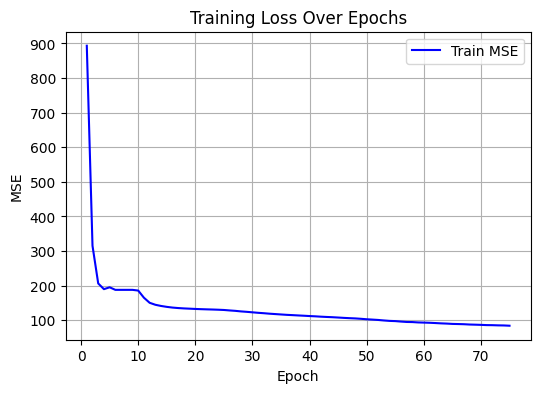

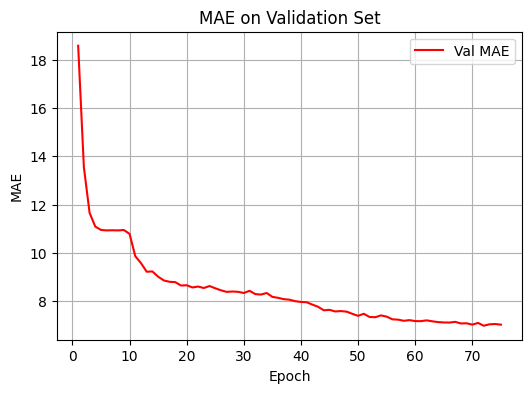

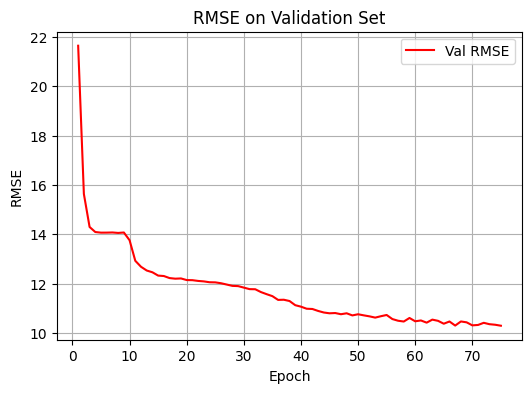

In [ ]:
# plot the 3 kinds of validation loss against epochs

import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

# plot training loss
plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss_history, 'b-', label='Train MSE')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()

# plotting validation MAE
plt.figure(figsize=(6,4))
plt.plot(epochs, val_mae_history, 'r-', label='Val MAE')
plt.title('MAE on Validation Set')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()

# plotting validation RMSE
plt.figure(figsize=(6,4))
plt.plot(epochs, val_rmse_history, 'r-', label='Val RMSE')
plt.title('RMSE on Validation Set')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

--


Now we define a new 'Custom ST-GAT' model that can be customized to have different numbers of LSTM layers and different levels of dropout applied within them depending on input specification, with the create_model function.

This will let us test different model architectures.


--

In [ ]:


class CustomST_GAT(nn.Module):
    """
    ST_GAT model class with flexible LSTM layers. Implemented so that:
    - first LSTM layer: input_size = n_nodes, hidden_size = 32
    - second LSTM layer: input_size = 32, hidden_size = 128
    - third and subsequent layers: input_size = 128, hidden_size = 128
    """

    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0, lstm_layers=2):
        super(CustomST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes
        self.lstm_layers = lstm_layers

        # GAT
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels, heads=heads, dropout=0, concat=False)

        # initialize LSTM layers using a ModuleList
        self.lstm_module_list = nn.ModuleList()

        # first layer: input_size = n_nodes, hidden_size = 32
        first_lstm = nn.LSTM(input_size=self.n_nodes, hidden_size=32, num_layers=1)
        self._init_lstm(first_lstm)
        self.lstm_module_list.append(first_lstm)

        # if we have at least 2 layers, define the second layer: input_size=32, hidden_size=128
        if self.lstm_layers >= 2:
            second_lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=1, dropout=0.0)

            self._init_lstm(second_lstm)
            self.lstm_module_list.append(second_lstm)

        # if we have more than 2 layers, subsequent layers have input_size=128, hidden_size=128
        # we apply dropout between these layers if lstm_layers > 2
        for i in range(3, self.lstm_layers+1):

            # for the i-th layer: input=128, hidden=128
            next_lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, dropout=(dropout if self.lstm_layers > 2 else 0.0))
            self._init_lstm(next_lstm)
            self.lstm_module_list.append(next_lstm)

        # The final hidden size depends on how many layers we have
        if self.lstm_layers == 1:
            self.final_hidden_size = 32
        else:
            # now, if we have >= 2 layers, the final hidden size is always 128
            self.final_hidden_size = 128

        # we output a linear layer
        self.linear = nn.Linear(self.final_hidden_size, self.n_nodes*self.n_pred)
        nn.init.xavier_uniform_(self.linear.weight)

    def _init_lstm(self, lstm):
      # method to initialize LSTM
        for name, param in lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)

    def forward(self, data, device):
        x, edge_index = data.x, data.edge_index
        if device != 'cpu':
            x = x.to(device)

        # we apply our GAT
        x = self.gat(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        batch_size = data.num_graphs
        n_node = int(data.num_nodes / batch_size)

        # reshape, move dims
        x = x.reshape(batch_size, n_node, data.num_features)
        x = torch.movedim(x, 2, 0)

        # pass through LSTM layers one by one
        x, _ = self.lstm_module_list[0](x)

        # if we have a second layer: (F, batch, 32) -> (F, batch, 128)
        if self.lstm_layers >= 2:
            x, _ = self.lstm_module_list[1](x)

        # if we have more than 2 layers, each of these layers will have (F, batch, 128) -> (F, batch, 128)
        if self.lstm_layers > 2:
            for i in range(2, self.lstm_layers):
                x, _ = self.lstm_module_list[i](x)

        # final time-step output
        x = x[-1, :, :]  # (batch, final_hidden_size)

        x = self.linear(x)  # (batch, n_node*n_pred)
        x = x.reshape(batch_size, n_node, self.n_pred)
        x = x.reshape(batch_size*n_node, self.n_pred)
        return x



def create_model(in_channels, out_channels, n_nodes, heads=8, dropout=0.0, lstm_layers=2):
    """
    This function will create an ST_GAT model with a variable number of LSTM layers:
    - if lstm_layers=1: first layer (32 dim)
    - if lstm_layers=2: first layer (32 dim), second layer (128 dim)
    - if lstm_layers>2: first layer (32 dim), second layer (128 dim),
                        with subsequent layers (128 dim each)
    """
    model = CustomST_GAT(
        in_channels=in_channels,
        out_channels=out_channels,
        n_nodes=n_nodes,
        heads=heads,
        dropout=dropout,
        lstm_layers=lstm_layers
    )
    return model

--


We've tested configurations with 2 and 4 LSTM layers, but we finally try three
more configugrations with 3 LSTM layers, one for each dropout setting.



--

In [ ]:
# now we test our model out with each of these final configurations of # of
# LSTM layers and dropout

# changed this a number of times to test different configs, can change more
configs = [
    {'lstm_layers': 3, 'dropout': 0.1},
    {'lstm_layers': 3, 'dropout': 0.2},
    {'lstm_layers': 3, 'dropout': 0.0}
]


in_channels = N_HIST
out_channels = N_PRED
n_nodes = N

results = []

# run it once for each configuration
for cfg in configs:

    print("=============================")
    print("")
    print("=============================")
    print(f"Training with config: lstm_layers={cfg['lstm_layers']}, dropout={cfg['dropout']}")
    print("=============================")
    print("")
    print("=============================")

    # lists to track performance
    train_loss_history = []
    val_mae_history = []
    val_smape_history = []
    val_rmse_history = []
    val_loss_history = []

    # build model
    model = create_model(in_channels, out_channels, n_nodes, heads=8, dropout=cfg['dropout'], lstm_layers=cfg['lstm_layers']).to(device)

    # define optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    num_epochs = 75
    for epoch in range(num_epochs):

        # --- Training ----
        model.train()
        train_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            pred = model(batch_data, device)
            loss = loss_fn(pred, batch_data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data.to(device)
                pred = model(batch_data, device)
                val_loss += loss_fn(pred, batch_data.y).item()

                all_preds.append(pred.cpu())
                all_targets.append(batch_data.y.cpu())

        val_loss /= len(val_loader)

        # Concatenate all the predictions / targets for our eval metrics
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # calculate eval metrics, add them to history
        val_mae = mean_absolute_error(all_preds, all_targets)
        val_rmse = root_mean_squared_error(all_preds, all_targets)
        val_smape = symmetric_mean_absolute_percentage_error(all_preds, all_targets)

        val_mae_history.append(val_mae)
        val_smape_history.append(val_smape)
        val_rmse_history.append(val_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f}")
        print(f"Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}, Val SMAPE: {val_smape}%")

        results.append({
        'config': cfg,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_mae_history': val_mae_history,
        'val_smape_history': val_smape_history,
        'val_rmse_history': val_rmse_history
    })


Training with config: lstm_layers=3, dropout=0.1



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1/75
Train MSE: 905.3610, Val MSE: 480.6321
Val MAE: 18.8227, Val RMSE: 21.9536, Val SMAPE: 73.16297149658203%
Epoch 2/75
Train MSE: 323.5807, Val MSE: 247.2451
Val MAE: 13.6849, Val RMSE: 15.7645, Val SMAPE: 55.22282028198242%
Epoch 3/75
Train MSE: 208.4308, Val MSE: 203.9944
Val MAE: 11.7227, Val RMSE: 14.3264, Val SMAPE: 50.15776062011719%
Epoch 4/75
Train MSE: 190.2376, Val MSE: 197.8015
Val MAE: 11.1159, Val RMSE: 14.1080, Val SMAPE: 48.794456481933594%
Epoch 5/75
Train MSE: 188.0807, Val MSE: 196.7678
Val MAE: 10.9713, Val RMSE: 14.0714, Val SMAPE: 48.4793586730957%
Epoch 6/75
Train MSE: 187.8879, Val MSE: 196.8167
Val MAE: 10.9455, Val RMSE: 14.0724, Val SMAPE: 48.445899963378906%
Epoch 7/75
Train MSE: 187.8793, Val MSE: 196.7154
Val MAE: 10.9366, Val RMSE: 14.0691, Val SMAPE: 48.44495391845703%
Epoch 8/75
Train MSE: 187.8784, Val MSE: 196.7994
Val MAE: 10.9523, Val RMSE: 14.0721, Val SMAPE: 48.48656463623047%
Epoch 9/75
Train MSE: 187.8893, Val MSE: 196.1079
Val MAE: 10.9

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/75
Train MSE: 905.2538, Val MSE: 480.2109
Val MAE: 18.8175, Val RMSE: 21.9440, Val SMAPE: 73.12590789794922%
Epoch 2/75
Train MSE: 323.3480, Val MSE: 246.7837
Val MAE: 13.6767, Val RMSE: 15.7500, Val SMAPE: 55.186851501464844%
Epoch 3/75
Train MSE: 208.3660, Val MSE: 204.0871
Val MAE: 11.7316, Val RMSE: 14.3296, Val SMAPE: 50.16404342651367%
Epoch 4/75
Train MSE: 190.2525, Val MSE: 197.4756
Val MAE: 11.1109, Val RMSE: 14.0966, Val SMAPE: 48.82088851928711%
Epoch 5/75
Train MSE: 188.0812, Val MSE: 197.1292
Val MAE: 10.9709, Val RMSE: 14.0838, Val SMAPE: 48.50898361206055%
Epoch 6/75
Train MSE: 187.8875, Val MSE: 196.9515
Val MAE: 10.9541, Val RMSE: 14.0777, Val SMAPE: 48.46403121948242%
Epoch 7/75
Train MSE: 187.8874, Val MSE: 196.9737
Val MAE: 10.9484, Val RMSE: 14.0783, Val SMAPE: 48.491477966308594%
Epoch 8/75
Train MSE: 187.8888, Val MSE: 196.9291
Val MAE: 10.9592, Val RMSE: 14.0767, Val SMAPE: 48.50182342529297%
Epoch 9/75
Train MSE: 187.8939, Val MSE: 197.0557
Val MAE: 10.

--

**Hyperparameter Tuning**

We conduct some tuning of a couple of the crucial hyperparameters in our model, the learning rate and the batch size, testing out different settings for each.

In [33]:
# now we turn to tuning hyperparamaters with our model architecture finalized



# we define different configurations of the hyperparameters to compare
# against each other

training_configs = [
    {'lr': 0.01, 'batch_size': 64},
    {'lr': 0.001,  'batch_size': 64},
    {'lr': 0.0005,  'batch_size': 64},
    {'lr': 0.01, 'batch_size': 32},
    {'lr': 0.001,  'batch_size': 32},
    {'lr': 0.0005,  'batch_size': 32}
]


in_channels = N_HIST
out_channels = N_PRED
n_nodes = N

# list for storing results
results = []

# run our training/eval loop for each hyperparamter configuration
for tcfg in training_configs:

    print("=============================")
    print("")
    print("=============================")
    print(f"Training with config: learning rate={tcfg['lr']}, batch size={tcfg['batch_size']}")
    print("=============================")
    print("")
    print("=============================")

    # initiate lists for storing performance history
    train_loss_history = []
    val_mae_history = []
    val_smape_history = []
    val_rmse_history = []
    val_loss_history = []

    # create model
    model = create_model(in_channels, out_channels, n_nodes, heads=8, dropout=0.2, lstm_layers=2).to(device)

    # employ current hyperparameter combination
    batch_size = tcfg['batch_size']
    lr = tcfg['lr']

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # define optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    num_epochs = 75
    for epoch in range(num_epochs):

        # --- Training ----
        model.train()
        train_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            pred = model(batch_data, device)
            loss = loss_fn(pred, batch_data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data.to(device)
                pred = model(batch_data, device)
                val_loss += loss_fn(pred, batch_data.y).item()

                all_preds.append(pred.cpu())
                all_targets.append(batch_data.y.cpu())

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        # we concatenate all the predictions / targets for our eval metrics
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # calculate eval metrics, add them to history
        val_mae = mean_absolute_error(all_preds, all_targets)
        val_rmse = root_mean_squared_error(all_preds, all_targets)
        val_smape = symmetric_mean_absolute_percentage_error(all_preds, all_targets)

        val_mae_history.append(val_mae)
        val_smape_history.append(val_smape)
        val_rmse_history.append(val_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f}")
        print(f"Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}, Val SMAPE: {val_smape}%")

        results.append({
        'training config': tcfg,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_mae_history': val_mae_history,
        'val_smape_history': val_smape_history,
        'val_rmse_history': val_rmse_history
    })


Training with config: learning rate=0.01, batch size=64

Epoch 1/75
Train MSE: 295.9022, Val MSE: 196.2458
Val MAE: 10.9274, Val RMSE: 14.0539, Val SMAPE: 48.56098175048828%
Epoch 2/75
Train MSE: 188.1922, Val MSE: 197.5852
Val MAE: 10.9324, Val RMSE: 14.0993, Val SMAPE: 48.400917053222656%
Epoch 3/75
Train MSE: 188.2742, Val MSE: 196.5456
Val MAE: 10.9207, Val RMSE: 14.0630, Val SMAPE: 48.38076400756836%
Epoch 4/75
Train MSE: 188.3297, Val MSE: 197.4254
Val MAE: 10.9845, Val RMSE: 14.0925, Val SMAPE: 48.60231399536133%
Epoch 5/75
Train MSE: 188.3494, Val MSE: 200.1388
Val MAE: 11.0066, Val RMSE: 14.1898, Val SMAPE: 48.49379348754883%
Epoch 6/75
Train MSE: 188.4491, Val MSE: 195.8160
Val MAE: 10.9152, Val RMSE: 14.0364, Val SMAPE: 48.4334831237793%
Epoch 7/75
Train MSE: 188.4329, Val MSE: 198.6273
Val MAE: 10.8855, Val RMSE: 14.1376, Val SMAPE: 48.228233337402344%
Epoch 8/75
Train MSE: 188.5208, Val MSE: 198.8167
Val MAE: 11.0097, Val RMSE: 14.1440, Val SMAPE: 48.606998443603516%
Epoc

--



Now that we have experimented with different model architectures and hyperparameter combinations and finalized our settings for each, we run our best model on the testing set to test out the effectiveness of our final model.




--

In [28]:
# lists for saving the progression of the different metrics
train_loss_history = []
test_loss_history = []
test_mae_history = []
test_rmse_history = []
test_smape_history = []

# use our best LR and batch size we learned from the hyperparamter tuning
final_lr = 0.0005
final_batch_size = 32

# instantiate our best model
final_model = create_model(in_channels, out_channels, n_nodes, heads=8, dropout=0.2, lstm_layers=2).to(device)

# instantiate optimzer and loss function with best learning rate
optimizer = torch.optim.Adam(final_model.parameters(), lr=final_lr)
loss_fn = nn.MSELoss()

# create dataloaders with best batch size
train_loader = DataLoader(train_data, batch_size=final_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=final_batch_size, shuffle=False)

# train the model with these final hyperparameters on the training data
for epoch in range(75):
    final_model.train()
    train_loss = 0
    for batch_data in train_loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        pred = final_model(batch_data, device)
        loss = loss_fn(pred, batch_data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    print(f"Epoch {epoch+1}/{75}, Train Loss: {train_loss:.4f}")

# begin evaluation on the test set
final_model.eval()
test_loss = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_data in test_loader:
        batch_data = batch_data.to(device)
        pred = final_model(batch_data, device)
        test_loss += loss_fn(pred, batch_data.y).item()

        all_preds.append(pred.cpu())
        all_targets.append(batch_data.y.cpu())

test_loss /= len(test_loader)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

test_mae = mean_absolute_error(all_preds, all_targets)
test_rmse = root_mean_squared_error(all_preds, all_targets)
test_smape = symmetric_mean_absolute_percentage_error(all_preds, all_targets)

print("===== Final Test Results =====")
print(f"Test MSE: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test SMAPE: {test_smape:.2f}%")

Epoch 1/75, Train Loss: 886.0783
Epoch 2/75, Train Loss: 320.9362
Epoch 3/75, Train Loss: 207.3293
Epoch 4/75, Train Loss: 189.8524
Epoch 5/75, Train Loss: 187.5214
Epoch 6/75, Train Loss: 160.7723
Epoch 7/75, Train Loss: 146.7923
Epoch 8/75, Train Loss: 140.2707
Epoch 9/75, Train Loss: 136.6591
Epoch 10/75, Train Loss: 134.4796
Epoch 11/75, Train Loss: 132.9370
Epoch 12/75, Train Loss: 131.7676
Epoch 13/75, Train Loss: 129.9584
Epoch 14/75, Train Loss: 127.5552
Epoch 15/75, Train Loss: 124.7626
Epoch 16/75, Train Loss: 122.3186
Epoch 17/75, Train Loss: 120.0612
Epoch 18/75, Train Loss: 118.1601
Epoch 19/75, Train Loss: 116.3501
Epoch 20/75, Train Loss: 114.8024
Epoch 21/75, Train Loss: 113.0622
Epoch 22/75, Train Loss: 111.2477
Epoch 23/75, Train Loss: 109.2293
Epoch 24/75, Train Loss: 106.9435
Epoch 25/75, Train Loss: 104.8667
Epoch 26/75, Train Loss: 102.9125
Epoch 27/75, Train Loss: 100.8821
Epoch 28/75, Train Loss: 99.1438
Epoch 29/75, Train Loss: 97.4926
Epoch 30/75, Train Loss: 